# Machine Learning Applied for Seabed Echo-Characterization
### Diogo Ceddia Porto Silva, Reinaldo Mozart da Gama e Silva, Arthur Ayres Neto

The main goal of this code is to extrapolate, using XGBoost, the echo-classification of seismic lines into a bigger area. The surface created is a result of statistic correlations between depth, backscatter, seafloor slope and two distance parameters (feature engeneering), which tryied to represent geological influence factors in echo-types definition.

The whole study encompass data conditioning and model/data explainability, all necessary steps to understand and build a reliable result.

This code, for me, is an interesting approach that could be (and maybe will!!) implemented in a seismic interpretation software: the possibility to correlate seismic classes with other spatial data, represented as overlaid grids.

#### Import and preprocess dataset1 (which contains validation data -> echo-types previously classified)

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv(r"C:\DCPS\Mestrado_DOT\ML KGB\kgb_data_ecos.txt",usecols=(0,1,2,3,4,5,6,7))
data.rename(columns = {'SLOPE_DIR':'ASPECT'}, inplace = True)
data = data[data.SLOPE < 50]

# Droping duplicated rows
print('Amount of rows in original dataset:',len(data))
duplicateDFRow = data[data.duplicated(subset=['Z','BS','SLOPE','ECO'])]
print('Amount of duplicated rows:', len(duplicateDFRow))
print('% filtered:', np.round(len(duplicateDFRow)/len(data)*100,3))
data.drop(axis=0, index=duplicateDFRow.index, inplace=True)
data = data.reset_index(drop=True)
print('Lenght of new dataset:',len(data),'\n')

print('% of Echo 1:',np.round((len(np.where(data.ECO==1)[0])/len(data))*100,3))
print('% of Echo 2:',np.round((len(np.where(data.ECO==2)[0])/len(data))*100,3))
print('% of Echo 3:',np.round((len(np.where(data.ECO==3)[0])/len(data))*100,3),'\n')
print(data.head())

Amount of rows in original dataset: 58027
Amount of duplicated rows: 43170
% filtered: 74.396
Lenght of new dataset: 14857 

% of Echo 1: 48.287
% of Echo 2: 14.875
% of Echo 3: 36.838 

               X             Y  ECO       BS        Z   SLOPE  distOUTFALL  \
0  444520.440866  3.113266e+06  1.0 -18.7150 -356.996  16.924   696.652597   
1  444517.146352  3.113268e+06  1.0 -19.0909 -355.959  15.770   699.927664   
2  444512.205077  3.113271e+06  1.0 -18.0734 -355.566  19.008   704.855998   
3  444510.557815  3.113273e+06  1.0 -18.2037 -354.981  11.394   706.502378   
4  444507.263288  3.113275e+06  1.0 -17.9550 -355.058   3.605   709.800910   

   distGLACIER  
0  4241.830832  
1  4239.349019  
2  4235.629696  
3  4234.391490  
4  4231.916882  


#### Preliminary training

In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import time
from sklearn import metrics
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

features = ['BS','Z','SLOPE','distOUTFALL','distGLACIER']
target = ['ECO']
X = data[features]
y = data[target]

X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X,columns=features)

proantar_model = XGBClassifier(eval_metric='error')

train_size=0.8
test_size=0.2
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0,
                                                        train_size=train_size, 
                                                        test_size=test_size, 
                                                        stratify=y.ECO)

start = time.time()
proantar_model.fit(X_train, y_train.values.ravel())
y_pred = proantar_model.predict(X_valid)
end=time.time()
y_pred = pd.DataFrame(y_pred,columns=['ECO'])

print('Training time',np.round((end-start),3),'seconds')
print(f'{train_size*100}% for training')
print(f'{test_size*100}% for validation')

# Metrics
precisao = metrics.balanced_accuracy_score(y_valid, y_pred)
print(f'\nBalanced Accuracy Score: {(precisao*100).round(3)}%')

Training time 3.36 seconds
80.0% for training
20.0% for validation

Balanced Accuracy Score: 98.154%


#### Confusion Matrix

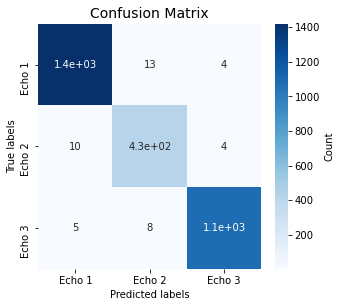

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = metrics.confusion_matrix(y_valid, y_pred)

fig, ax = plt.subplots(figsize=(5,4.5))
# ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap = 'Blues', cbar_kws={'label': 'Count'});
# labels, title and ticks
ax.set_title('Confusion Matrix', size=14); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['Echo 1', 'Echo 2', 'Echo 3'])
ax.yaxis.set_ticklabels(['Echo 1', 'Echo 2', 'Echo 3']);

#### Feature Importance

6.51329493522644


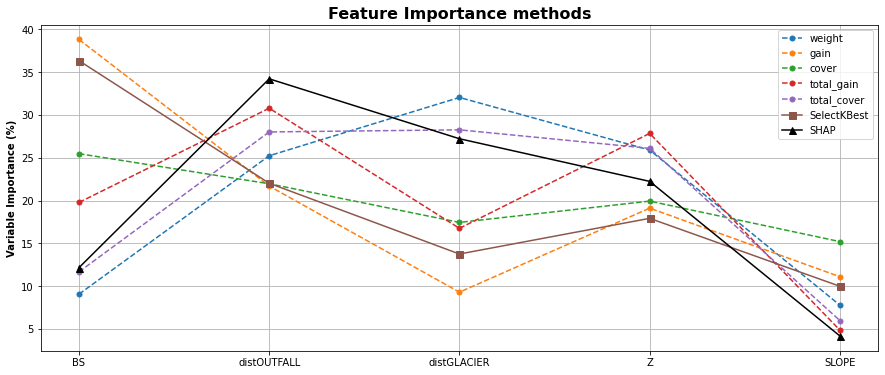

In [4]:
import shap

start=time.time()
explainer = shap.TreeExplainer(proantar_model)
shap_values = explainer.shap_values(X_train)
end=time.time()
print(end-start)

shap_sum1 = np.abs(shap_values[0]).mean(axis=0)
importance_df1 = pd.DataFrame([X_train.columns.tolist(), shap_sum1.tolist()]).T
importance_df1.columns = ['column_name', 'imp']
shap_sum2 = np.abs(shap_values[1]).mean(axis=0)
importance_df2 = pd.DataFrame([X_train.columns.tolist(), shap_sum2.tolist()]).T
importance_df2.columns = ['column_name', 'imp']
shap_sum3 = np.abs(shap_values[2]).mean(axis=0)
importance_df3 = pd.DataFrame([X_train.columns.tolist(), shap_sum3.tolist()]).T
importance_df3.columns = ['column_name', 'imp']

a = importance_df1.imp * (len(np.where(data.ECO==1)[0])/len(data))
b = importance_df2.imp * (len(np.where(data.ECO==2)[0])/len(data))
c = importance_df3.imp * (len(np.where(data.ECO==3)[0])/len(data))
imp_shap = a+b+c
imp_shap.index = importance_df1.column_name
imp_shap = imp_shap.reindex(['BS','distOUTFALL','distGLACIER','Z','SLOPE'])

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

testKbest = SelectKBest(score_func=f_classif, k=len(features))
fitKbest = testKbest.fit(X_train, y_train.values.ravel())
dff = pd.DataFrame(fitKbest.scores_,index=features)
dff.columns=['k']
dff = dff.reindex(['BS','distOUTFALL','distGLACIER','Z','SLOPE'])

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,6))
plt.title('Feature Importance methods',size=16,fontweight='bold')
plt.ylabel('Variable Importance (%)',fontweight='bold')

imp = pd.DataFrame(list(proantar_model.get_booster().get_score(importance_type='weight').items()),columns=['features','importance'])
x = imp.features
y = (imp.importance/sum(imp.importance))*100
plt.plot(x,y,marker='.',markersize=10, label='weight', linestyle='dashed')

imp = pd.DataFrame(list(proantar_model.get_booster().get_score(importance_type='gain').items()),columns=['features','importance'])
x = imp.features
y = (imp.importance/sum(imp.importance))*100
plt.plot(x,y,marker='.',markersize=10,label='gain', linestyle='dashed')

imp = pd.DataFrame(list(proantar_model.get_booster().get_score(importance_type='cover').items()),columns=['features','importance'])
x = imp.features
y = (imp.importance/sum(imp.importance))*100
plt.plot(x,y,marker='.',markersize=10,label='cover', linestyle='dashed')

imp = pd.DataFrame(list(proantar_model.get_booster().get_score(importance_type='total_gain').items()),columns=['features','importance'])
x = imp.features
y = (imp.importance/sum(imp.importance))*100
plt.plot(x,y,marker='.',markersize=10,label='total_gain', linestyle='dashed')

imp = pd.DataFrame(list(proantar_model.get_booster().get_score(importance_type='total_cover').items()),columns=['features','importance'])
x = imp.features
y = (imp.importance/sum(imp.importance))*100
plt.plot(x,y,marker='.',markersize=10,label='total_cover', linestyle='dashed')

plt.plot(dff.index, (dff.k/sum(dff.k))*100, marker='s', markersize=7, label='SelectKBest')

plt.plot(imp_shap.index, (imp_shap/sum(imp_shap))*100, marker='^', markersize=7, label='SHAP', color='black')

plt.legend()
plt.grid(b=True,axis='both')
plt.show()

#### SHAP values

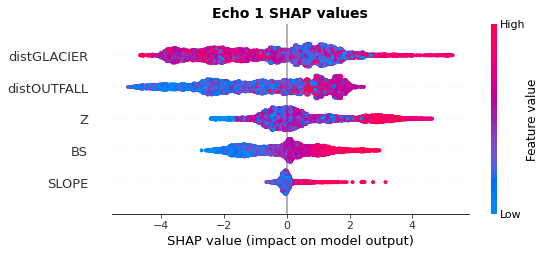

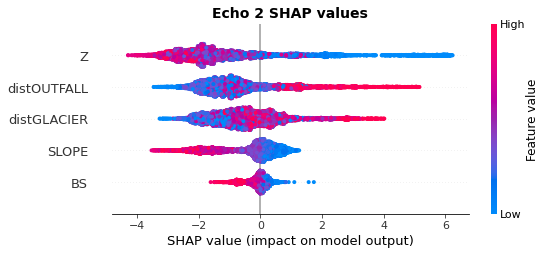

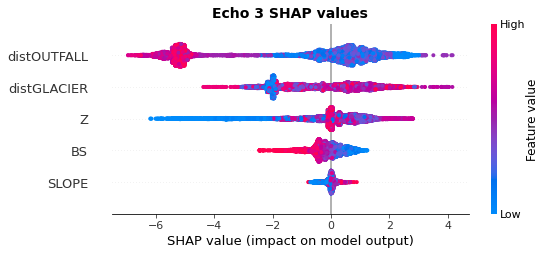

In [5]:
import shap
import matplotlib.pyplot as plt

fig = plt.figure()
plt.title('Echo 1 SHAP values',fontsize=14,fontweight="bold")
shap.summary_plot(shap_values[0], X_train,)

fig = plt.figure()
plt.title('Echo 2 SHAP values',fontsize=14,fontweight="bold")
shap.summary_plot(shap_values[1], X_train)

fig = plt.figure()
plt.title('Echo 3 SHAP values',fontsize=14,fontweight="bold")
shap.summary_plot(shap_values[2], X_train)


#### Manual RFE (all possible combinations of n features)

In [6]:
from itertools import combinations

lista = []
for L in range(0, len(features)+1):
    for subset in combinations(features, L):
        lista.append(subset)
del lista[0]
        
data_it=data.copy()

start_ = time.time()

v=1
for i in range(v):

    y_it = data_it[target]
    globals()['iteracoes_%d' % i] = []

    for j in range(len(lista)):
        start=time.time()

        X_iter = data_it[np.asarray([''.join(i) for i in lista[j]])]

        X_iter = StandardScaler().fit_transform(X_iter)
        X_iter = pd.DataFrame(X_iter)

        X_iter_train, X_iter_valid, y_iter_train, y_iter_valid = train_test_split(X_iter, y_it, random_state=0,
                                                            train_size=train_size,
                                                            test_size=test_size,
                                                            stratify=y_it.ECO)

        proantar_model_iter = XGBClassifier(eval_metric='error')
        proantar_model_iter.fit(X_iter_train, y_iter_train.values.ravel())
        y_pred_iter = proantar_model_iter.predict(X_iter_valid)
        end=time.time()
        precisao_iter = metrics.balanced_accuracy_score(y_iter_valid, y_pred_iter)
        globals()['iteracoes_%d' % i].append((precisao_iter,[''.join(i) for i in lista[j]]))

end_ = time.time()
print(end_-start_)

for k in range(v):
    globals()['lista_valores_%d' % k] = []
    for i in range(len(iteracoes_0)):
        globals()['lista_valores_%d' % k].append(globals()['iteracoes_%d' % k][i][0])

accu = np.array(globals()['lista_valores_0'])
for i in range(k):
    print(i)
    accu = accu + np.array(globals()['lista_valores_%d' % (i+1)])
accu = accu/(k+1)
    
df=pd.DataFrame(accu)
df=df.T
df.columns=lista
df=df.T
df.columns=['accuracy']
df = df.sort_values(by=['accuracy'],ascending=False)

pd.set_option("display.max_rows", None, "display.max_columns", None)
df

89.91442203521729


,accuracy
"(BS, Z, SLOPE, distOUTFALL, distGLACIER)",0.981536
"(Z, distOUTFALL, distGLACIER)",0.980534
"(Z, SLOPE, distOUTFALL, distGLACIER)",0.979491
"(BS, Z, distOUTFALL, distGLACIER)",0.979186
"(BS, SLOPE, distOUTFALL, distGLACIER)",0.961550
"(BS, distOUTFALL, distGLACIER)",0.954270
"(BS, Z, SLOPE, distGLACIER)",0.954021
"(BS, Z, distGLACIER)",0.952962
"(SLOPE, distOUTFALL, distGLACIER)",0.949523
"(Z, SLOPE, distGLACIER)",0.949016


#### Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix')

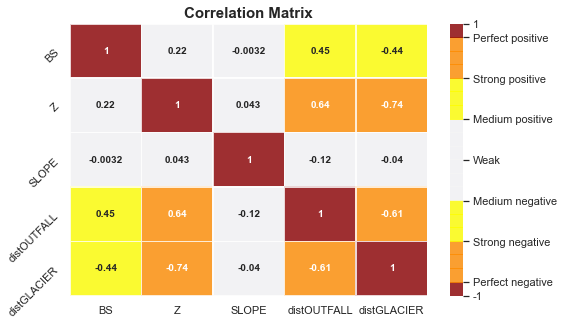

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

correlated_features = set()
correlation_matrix = X.corr(method='spearman')

sns.set(font_scale=1)

colors = ['darkred',
          'darkorange','darkorange','darkorange',
          'yellow','yellow','yellow',
          'whitesmoke','whitesmoke','whitesmoke','whitesmoke','whitesmoke','whitesmoke',
          'yellow','yellow','yellow',
          'darkorange','darkorange','darkorange',
          'darkred']
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax = sns.heatmap(correlation_matrix, vmin=-1, vmax = 1 ,cmap=cmap, annot=True, 
                 linewidths = .5, alpha=0.8, annot_kws = {"fontsize":10,"fontweight":"bold"})
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([-1, -0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9, 1])
c_bar.set_ticklabels(['-1',
                      'Perfect negative',
                      'Strong negative', 
                      'Medium negative',
                      'Weak',
                      'Medium positive',
                      'Strong positive',
                      'Perfect positive',
                      '1'])

plt.yticks(rotation=45)
plt.title('Correlation Matrix',fontsize=15,fontweight="bold")

#### PCA

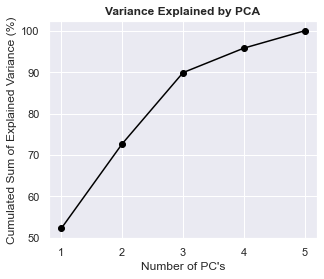

In [8]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

pca_test = decomposition.PCA(n_components=len(features))
x_std_test = StandardScaler().fit_transform(X_train)
components_test = pca_test.fit_transform(x_std_test)

fig = plt.figure(figsize=(4.8,4))
plt.plot(np.arange(1,len(pca_test.explained_variance_ratio_)+1,1),
          np.cumsum(pca_test.explained_variance_ratio_)*100,
          '-o',color='black')
plt.xlabel("Number of PC's")
plt.ylabel("Cumulated Sum of Explained Variance (%)")
plt.title("Variance Explained by PCA",fontweight='bold')
plt.xticks(np.arange(1,len(pca_test.explained_variance_ratio_)+1,1))
plt.grid(which='both')
plt.grid()

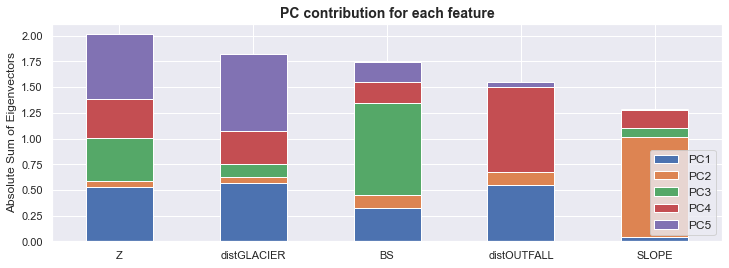

In [9]:
# PCA for 6 PC's

from sklearn import decomposition
import matplotlib.pyplot as plt

pca = decomposition.PCA(n_components=5)
x_std = StandardScaler().fit_transform(X_train)
components = pca.fit_transform(x_std)

odf = pd.DataFrame(pca.components_, columns=X_train.columns, index = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
odf = odf.T.abs()
odf['sum'] = odf.sum(axis = 1)
odf.sort_values(by='sum', ascending = False)[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].plot.bar(stacked = True, figsize = (12,4))

plt.title('PC contribution for each feature',fontsize=14,fontweight="bold")
plt.ylabel('Absolute Sum of Eigenvectors')
plt.xticks(rotation=360)
plt.legend(prop={'size': 12})

#### Uncertanty map of Dataset1

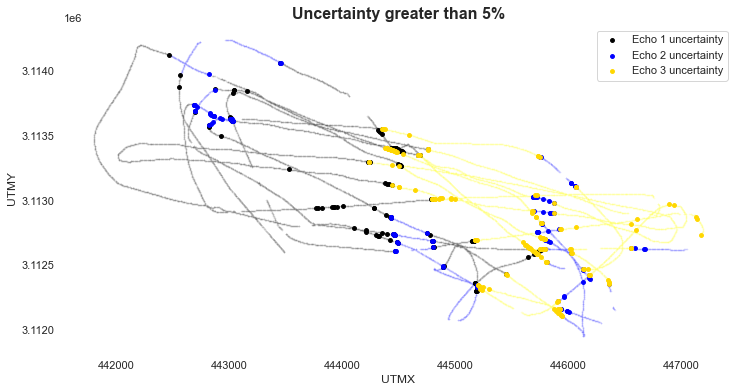

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['axes.facecolor'] = 'white'
size = 60

fig = plt.figure(figsize=(12,6))
plt.scatter(data.X.iloc[np.where(data.ECO ==1)[0]], data.Y.iloc[np.where(data.ECO ==1)[0]],
            s=1, color='black', marker='*', alpha=0.1)
plt.scatter(data.X.iloc[np.where(data.ECO ==2)[0]], data.Y.iloc[np.where(data.ECO ==2)[0]], 
            s=1, color='blue', marker='*', alpha=0.1)
plt.scatter(data.X.iloc[np.where(data.ECO ==3)[0]], data.Y.iloc[np.where(data.ECO ==3)[0]],
            s=1, color='yellow', marker='*', alpha=0.1)

incerteza = proantar_model.predict_proba(X)

plt.scatter(data.X.iloc[np.where(((incerteza[:,0] < 0.95) * data.ECO == 1)==True)[0]],
            data.Y.iloc[np.where(((incerteza[:,0] < 0.95) * data.ECO == 1)==True)[0]],
            s=size, color='black', marker='.', label='Echo 1 uncertainty')
plt.scatter(data.X.iloc[np.where(((incerteza[:,1] < 0.95) * data.ECO == 2)==True)[0]],
            data.Y.iloc[np.where(((incerteza[:,1] < 0.95) * data.ECO == 2)==True)[0]],
            s=size, color='blue', marker='.', label='Echo 2 uncertainty')
plt.scatter(data.X.iloc[np.where(((incerteza[:,2] < 0.95) * data.ECO == 3)==True)[0]],
            data.Y.iloc[np.where(((incerteza[:,2] < 0.95) * data.ECO == 3)==True)[0]],
            s=size, color='gold', marker='.', label='Echo 3 uncertainty')

plt.title('Uncertainty greater than 5%',size=16,fontweight='bold')
plt.xlabel('UTMX')
plt.ylabel('UTMY')
plt.legend()
plt.grid(c='grey',alpha=0.5)


#### Data extrapolation. Training with Dataset1 and predicting with Dataset 2 (w/o validation data)

In [11]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import time
from sklearn import metrics

data_all = pd.read_csv(r"C:\DCPS\Mestrado_DOT\ML KGB\kgb_data_all.txt",usecols=(0,1,2,3,4,5,6))
data_all = data_all[data_all.SLOPE < 50]
data_treino = data

features = ['BS','Z','SLOPE','distOUTFALL','distGLACIER']
target = ['ECO']
     
X_test = data_all[features]
X = data_treino[features]
y = data_treino[target]

proantar_model_all = XGBClassifier(eval_metric='error')

start = time.time()
proantar_model_all.fit(X, y.values.ravel())
y_pred_all = proantar_model_all.predict(X_test)
end=time.time()

y_pred_all = pd.DataFrame(y_pred_all,columns=['ECO'])
print('Tempo:',end-start,'segundos')
print(data_all.head())

Tempo: 5.59497857093811 segundos
          X          Y       BS        Z   SLOPE  distGLACIER  distOUTFALL
0  442440.0  3112740.0 -16.5920 -238.512   5.244  3851.899776  1564.343390
1  442445.0  3112740.0 -17.3450 -239.175   2.011  3856.278563  1561.332332
2  442450.0  3112740.0 -17.5490 -239.112   3.269  3860.658859  1558.331499
3  442420.0  3112745.0 -15.2976 -237.406  12.283  3831.976166  1580.448763
4  442425.0  3112745.0 -15.9332 -237.993   2.460  3836.351627  1577.405053


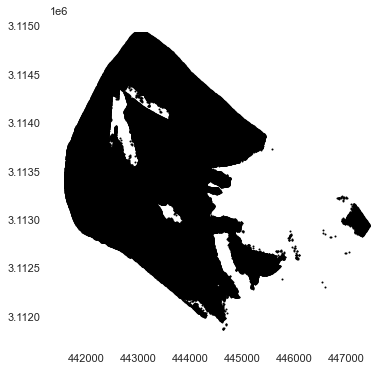

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,6))
plt.scatter(data_all.X[np.where(y_pred_all == 1)[0]],data_all.Y[np.where(y_pred_all == 1)[0]],s=1, color='black')
plt.show()

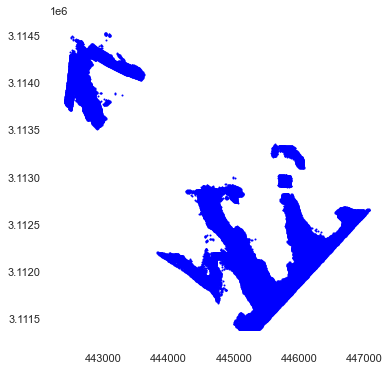

In [13]:
fig = plt.figure(figsize=(6,6))
plt.scatter(data_all.X[np.where(y_pred_all == 2)[0]],data_all.Y[np.where(y_pred_all == 2)[0]],s=1, color='blue')
plt.show()

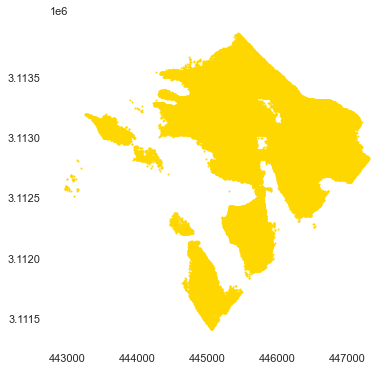

In [14]:
fig = plt.figure(figsize=(6,6))
plt.scatter(data_all.X[np.where(y_pred_all == 3)[0]],data_all.Y[np.where(y_pred_all == 3)[0]],s=1, color='gold')
plt.show()

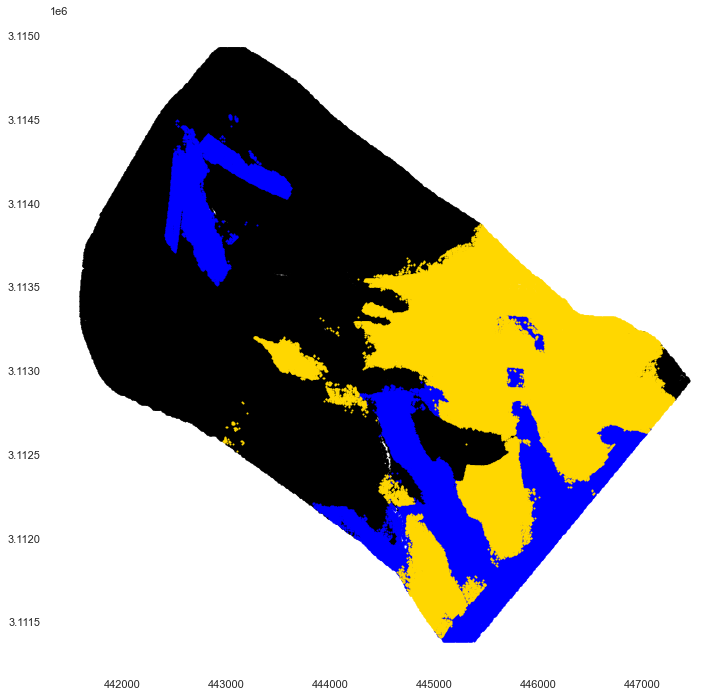

In [15]:
fig = plt.figure(figsize=(12,12))
plt.scatter(data_all.X[np.where(y_pred_all == 1)[0]],data_all.Y[np.where(y_pred_all == 1)[0]],s=1, color='black')
plt.scatter(data_all.X[np.where(y_pred_all == 2)[0]],data_all.Y[np.where(y_pred_all == 2)[0]],s=1, color='blue')
plt.scatter(data_all.X[np.where(y_pred_all == 3)[0]],data_all.Y[np.where(y_pred_all == 3)[0]],s=1, color='gold')
plt.show()

In [16]:
# Creating variables to export to global mapper
pred_xy1_all = data_all.iloc[np.where(y_pred_all == 1)[0]].reset_index(drop=True)
pred_xy1_all['ECO']= 1
pred_xy2_all = data_all.iloc[np.where(y_pred_all == 2)[0]].reset_index(drop=True)
pred_xy2_all['ECO']= 2
pred_xy3_all = data_all.iloc[np.where(y_pred_all == 3)[0]].reset_index(drop=True)
pred_xy3_all['ECO']= 3